In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm

In [2]:
ames = pd.read_csv('./datasets/train_clean.csv', na_values = 'NaN', keep_default_na=False, index_col=0)

In [3]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2047 non-null   int64  
 1   PID              2047 non-null   int64  
 2   MS SubClass      2047 non-null   int64  
 3   MS Zoning        2047 non-null   object 
 4   Lot Frontage     2047 non-null   float64
 5   Lot Area         2047 non-null   int64  
 6   Street           2047 non-null   object 
 7   Alley            2047 non-null   object 
 8   Lot Shape        2047 non-null   object 
 9   Land Contour     2047 non-null   object 
 10  Utilities        2047 non-null   object 
 11  Lot Config       2047 non-null   object 
 12  Land Slope       2047 non-null   object 
 13  Neighborhood     2047 non-null   object 
 14  Condition 1      2047 non-null   object 
 15  Condition 2      2047 non-null   object 
 16  Bldg Type        2047 non-null   object 
 17  House Style   

In [4]:
#Important feature

ames['Age'] = ames['Yr Sold'] - ames['Year Built']

Get the correlation heatmap for numeric features with sales price:

# Correlation Heatmap

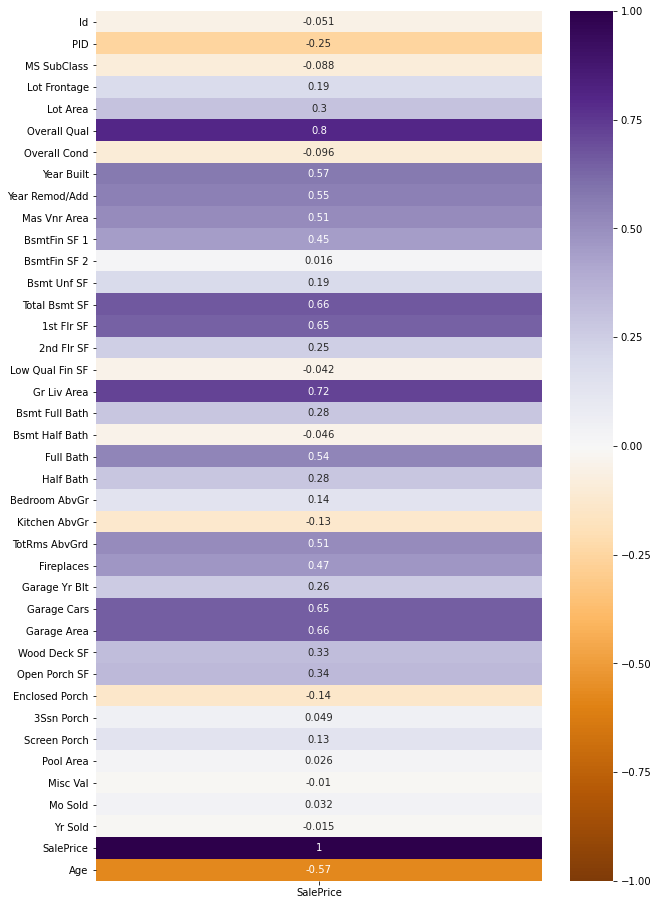

In [5]:
plt.figure(figsize=(10,16))
sns.heatmap(ames.corr()[['SalePrice']], cmap = 'PuOr', annot = True, vmax = 1, vmin = -1);

In [6]:
#Potentially important numeric features from correlation heatmap:

key_features = ['Overall Qual', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Yr Sold', 'Garage Area']

# Pair Plot 
#### With features that have higher corellation with Sales Price above

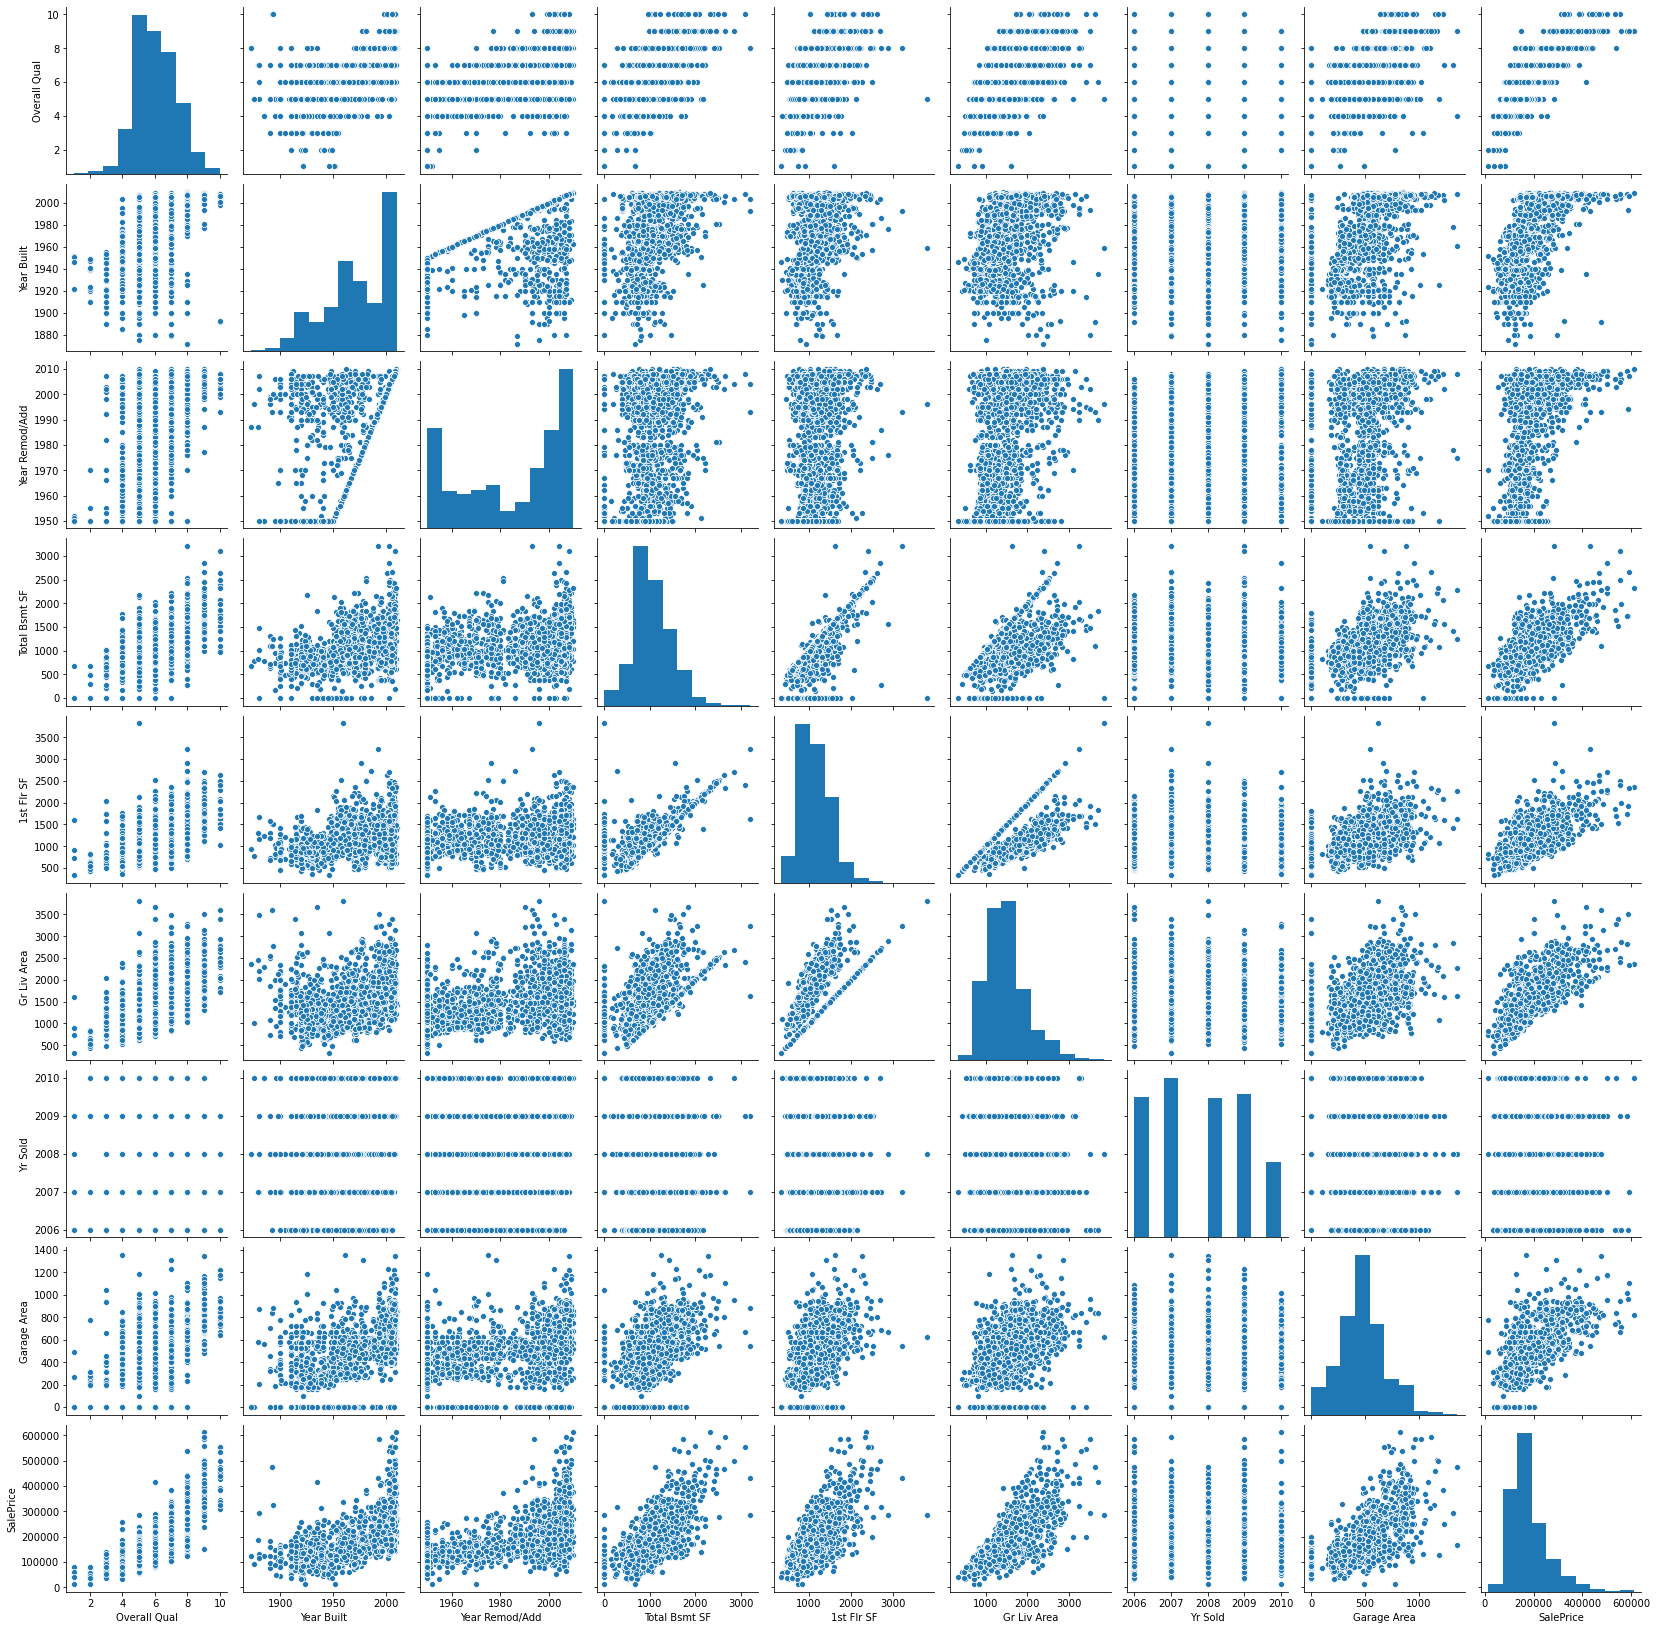

In [7]:
sns.pairplot(ames[key_features].join(ames['SalePrice']))

In [8]:
#This funciton takes 4 features to compare to y and plots them all, then prints the correlation

def compare4(x1, x1_title, x2, x2_title, x3, x3_title, x4, x4_title, y, y_title):
    fig, axs = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    axs[0,0].scatter(x1, y, s = 3, alpha = 0.3, c = 'darkorange')
    axs[0,0].title.set_text(f'{x1_title} vs {y_title}')
    axs[0,1].scatter(x2, y, s = 3, alpha = 0.3)
    axs[0,1].title.set_text(f'{x2_title} vs {y_title}')
    axs[1,0].scatter(x3, y, s = 3, alpha = 0.3)
    axs[1,0].title.set_text(f'{x3_title} vs {y_title}')
    axs[1,1].scatter(x4, y, s = 3, alpha = 0.3)
    axs[1,1].title.set_text(f'{x4_title} vs {y_title}')

    plt.show()

    print(f'{x1_title} Correlation:')
    print(np.corrcoef(x1,y)[0,1])
    print(f'{x2_title} Correlation:')
    print(np.corrcoef(x2,y)[0,1])
    print(f'{x3_title} Correlation:')
    print(np.corrcoef(x3,y)[0,1])
    print(f'{x4_title} Correlation:')
    print(np.corrcoef(x4,y)[0,1])

# Feature Interactions

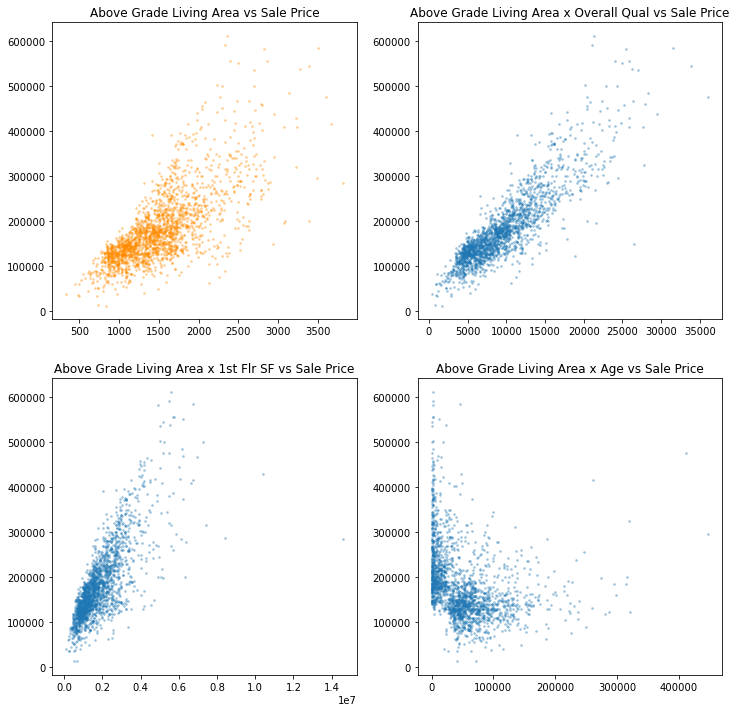

Above Grade Living Area Correlation:
0.7194825662999712
Above Grade Living Area x Overall Qual Correlation:
0.8728886562052958
Above Grade Living Area x 1st Flr SF Correlation:
0.7636001218659009
Above Grade Living Area x Age Correlation:
-0.32653031956634265


In [9]:
primary_feature_name = 'Above Grade Living Area'
primary_feature = ames['Gr Liv Area']

compare4(primary_feature,
        primary_feature_name,
        primary_feature * ames['Overall Qual'],
        primary_feature_name + ' x Overall Qual',
        primary_feature * ames['1st Flr SF'],
        primary_feature_name + ' x 1st Flr SF',
        primary_feature * ames['Age'],
        primary_feature_name + ' x Age',
        ames['SalePrice'], 'Sale Price')

**Gr Liv Area**

Gr Liv Area shows the strongest correlation with sales price (other than Quality). Combining this feature with Overall Quality improves the correlation.

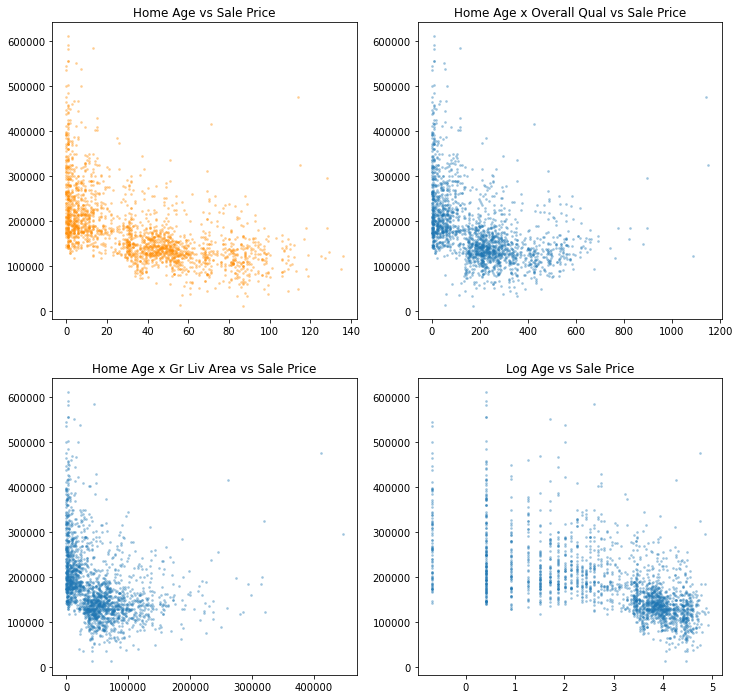

Home Age Correlation:
-0.5723095489493659
Home Age x Overall Qual Correlation:
-0.4472384190971592
Home Age x Gr Liv Area Correlation:
-0.32653031956634265
Log Age Correlation:
-0.6205294520162592


In [10]:
primary_feature_name = 'Home Age'
primary_feature = ames['Age']

compare4(primary_feature,
        primary_feature_name,
        primary_feature * ames['Overall Qual'],
        primary_feature_name + ' x Overall Qual',
        primary_feature * ames['Gr Liv Area'],
        primary_feature_name + ' x Gr Liv Area',
        np.log(ames['Age']+0.5),
        'Log Age',
        ames['SalePrice'], 'Sale Price')

**Home Age**

Home age, being more intepretable than Year Built, was extracted from Year Built and Year Sold columns. This represents the home's age at the time of sale.

Correlation is strongest without any combinations. It may be slightly improved by taking the log (and adding 6 months to estimate average age, but more importantly to avoid taking the log of 0).

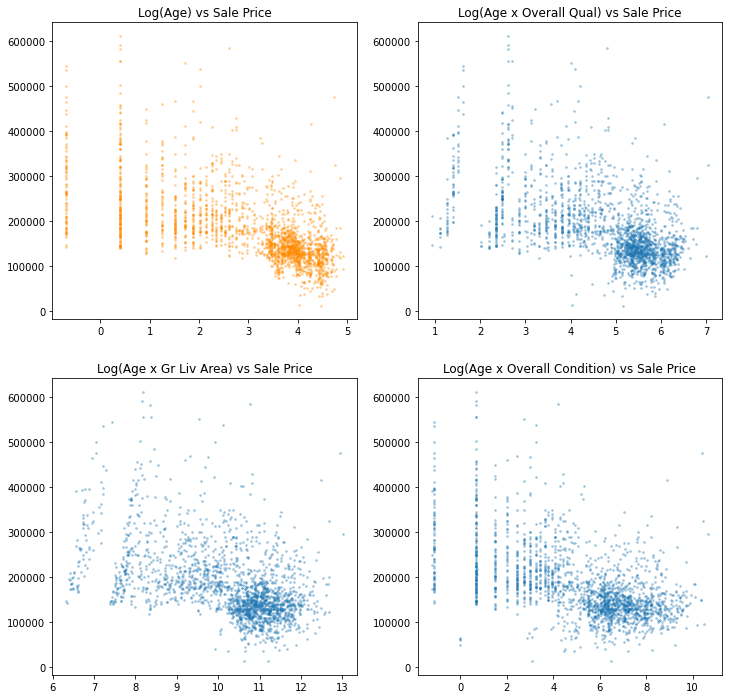

Log(Age) Correlation:
-0.6205294520162592
Log(Age x Overall Qual) Correlation:
-0.5430060787144142
Log(Age x Gr Liv Area) Correlation:
-0.4893762803871301
Log(Age x Overall Condition) Correlation:
-0.5491598502944921


In [11]:
primary_feature_name = 'Log(Age'
primary_feature = np.log(ames['Age'] + .5)

compare4(primary_feature,
        primary_feature_name + ')',
        primary_feature + np.log(ames['Overall Qual']),
        primary_feature_name + ' x Overall Qual)',
        primary_feature + np.log(ames['Gr Liv Area']),
        primary_feature_name + ' x Gr Liv Area)',
        primary_feature * np.log(ames['Overall Cond']),
        primary_feature_name + ' x Overall Condition)',
        ames['SalePrice'], 'Sale Price')

# Log(a) + Log(b) = Log(a * b)

**Log (Home Age)**

Combining Log of Age with other columns did not yield any improvements.

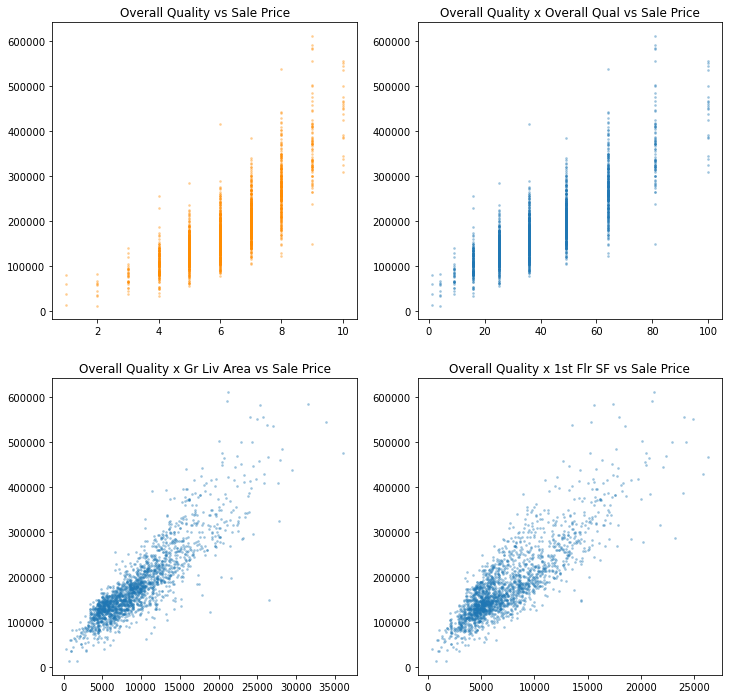

Overall Quality Correlation:
0.803286856199859
Overall Quality x Overall Qual Correlation:
0.8304443738312997
Overall Quality x Gr Liv Area Correlation:
0.8728886562052958
Overall Quality x 1st Flr SF Correlation:
0.8407751903037237


In [12]:
primary_feature_name = 'Overall Quality'
primary_feature = ames['Overall Qual']

compare4(primary_feature,
        primary_feature_name,
        primary_feature * ames['Overall Qual'],
        primary_feature_name + ' x Overall Qual',
        primary_feature * ames['Gr Liv Area'],
        primary_feature_name + ' x Gr Liv Area',
        primary_feature * ames['1st Flr SF'],
        primary_feature_name + ' x 1st Flr SF',
        ames['SalePrice'], 'Sale Price')

**Overall Quality**

Quality is a quasi-categorical qualitative estimate... but it shows the strongest correlation of any numerical column. Combinations with other data only gives minor improvements over quality alone or quality squared. Still, given the categorical nature of the data, I would like to combine with other data for use in models.

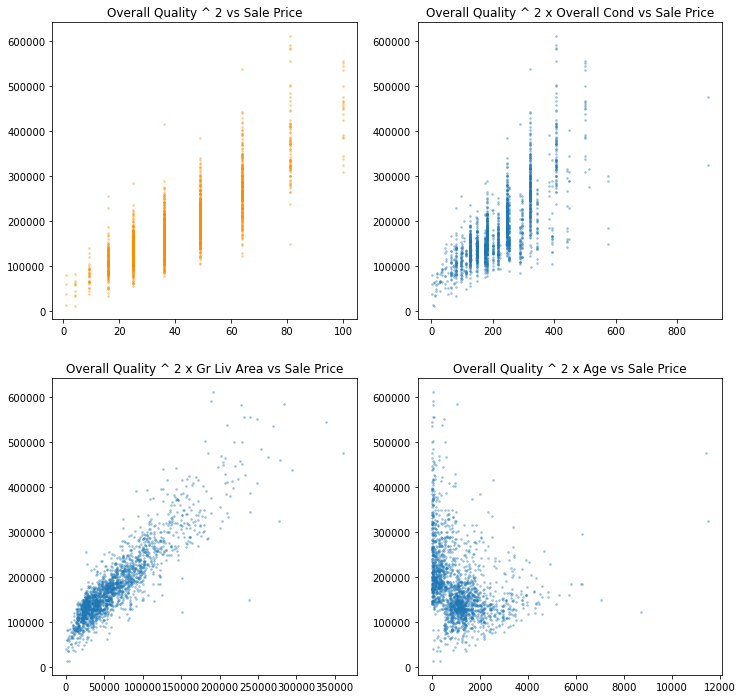

Overall Quality ^ 2 Correlation:
0.8304443738312997
Overall Quality ^ 2 x Overall Cond Correlation:
0.7504773820112524
Overall Quality ^ 2 x Gr Liv Area Correlation:
0.8960478815216085
Overall Quality ^ 2 x Age Correlation:
-0.2910159991679467


In [13]:
primary_feature_name = 'Overall Quality ^ 2'
primary_feature = ames['Overall Qual'] ** 2

compare4(primary_feature,
        primary_feature_name,
        primary_feature * ames['Overall Cond'],
        primary_feature_name + ' x Overall Cond',
        primary_feature * ames['Gr Liv Area'],
        primary_feature_name + ' x Gr Liv Area',
        primary_feature * ames['Age'],
        primary_feature_name + ' x Age',
        ames['SalePrice'], 'Sale Price')

**Quality ^2**

Quality squared appears more linear than quality alone, and has a slightly higher correlation coefficient. Attempting to combine it with other columns shows that the size of the home improves the correlation, but this combination isn't much of an improvement over Quality x Gr Liv Area.

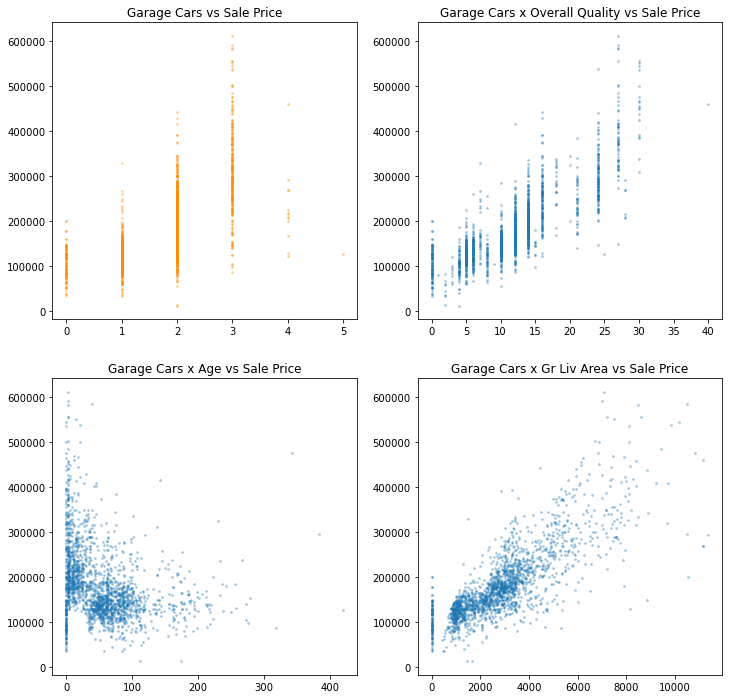

Garage Cars Correlation:
0.6484535581853895
Garage Cars x Overall Quality Correlation:
0.8221396690196763
Garage Cars x Age Correlation:
-0.31146365257037373
Garage Cars x Gr Liv Area Correlation:
0.8065061244686852


In [14]:
primary_feature_name = 'Garage Cars'
primary_feature = ames['Garage Cars']

compare4(primary_feature,
        primary_feature_name,
        primary_feature * ames['Overall Qual'],
        primary_feature_name + ' x Overall Quality',
        primary_feature * ames['Age'],
        primary_feature_name + ' x Age',
        primary_feature * ames['Gr Liv Area'],
        primary_feature_name + ' x Gr Liv Area',
        ames['SalePrice'], 'Sale Price')

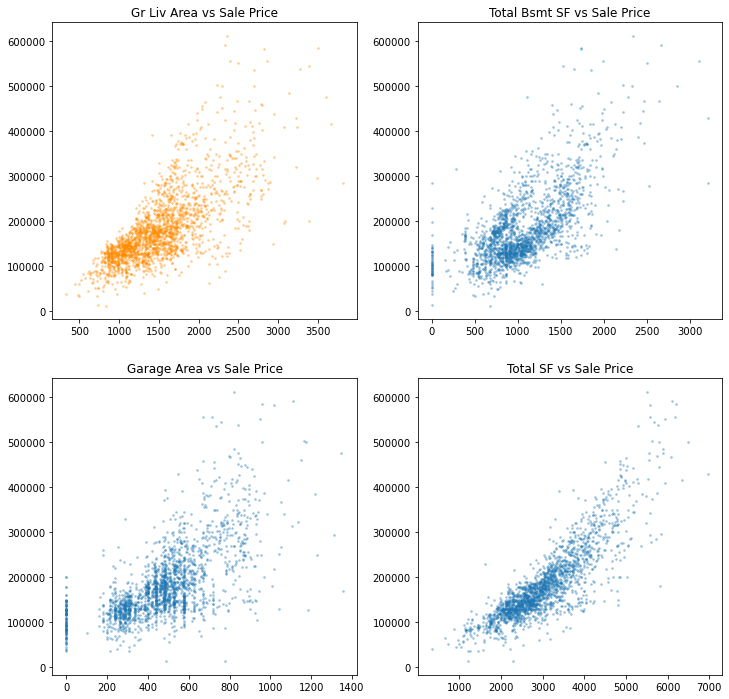

Gr Liv Area Correlation:
0.7194825662999712
Total Bsmt SF Correlation:
0.6647904761652136
Garage Area Correlation:
0.6553116955212143
Total SF Correlation:
0.8536598281081871


In [15]:
compare4(ames['Gr Liv Area'],
        'Gr Liv Area',
        ames['Total Bsmt SF'],
        'Total Bsmt SF',
        ames['Garage Area'],
        'Garage Area',
        ames['Gr Liv Area'] + ames['Total Bsmt SF'] + ames['Garage Area'],
        'Total SF',
        ames['SalePrice'], 'Sale Price')

**Various Areas and Price**

Plots of Basement, Above Ground, and Garage Areas vs Sale Price. A simple combination of the three provides a much tighter plot. However, it is unlikely that Basement, Garage, and Above-Grade Living space would be weighted equally.

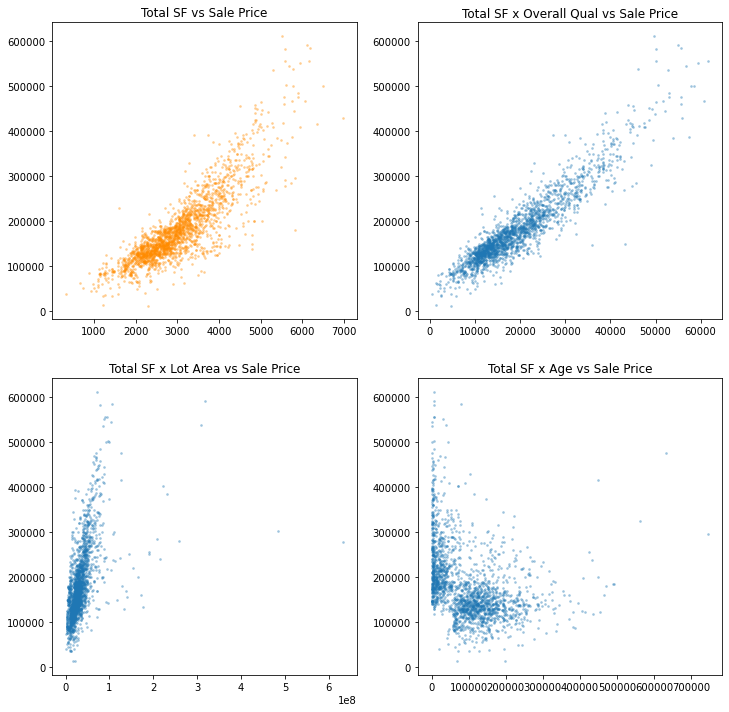

Total SF Correlation:
0.8536598281081871
Total SF x Overall Qual Correlation:
0.9276566308210435
Total SF x Lot Area Correlation:
0.5325429754862707
Total SF x Age Correlation:
-0.36688296630611983


In [16]:
primary_feature_name = 'Total SF'
primary_feature = ames['Gr Liv Area'] + ames['Total Bsmt SF'] + ames['Garage Area']

compare4(primary_feature,
        primary_feature_name,
        primary_feature * ames['Overall Qual'],
        primary_feature_name + ' x Overall Qual',
        primary_feature * ames['Lot Area'],
        primary_feature_name + ' x Lot Area',
        primary_feature * ames['Age'],
        primary_feature_name + ' x Age',
        ames['SalePrice'], 'Sale Price')

**Total Area**

Multiplying Total SF by Overall Condition provides a good candidate on which to base a regression model.

# Categorical Features

In [17]:
# First, organize lists of categorical column names

sale_category_cols = ['Yr Sold', 'Sale Type', 'MS SubClass', 'MS Zoning']
lot_category_cols =  ['Lot Shape', 'Land Contour', 'Lot Config', 'Land Slope', 'Alley']
characteristics_category_cols = ['Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation']
rooms_category_cols = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',  'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces']
garage_category_cols = ['Garage Type', 'Garage Finish', 'Garage Cars']
features_category_cols = ['Fence', 'Misc Feature', 'Paved Drive']
condition_category_cols = ['Functional', 'Garage Cond', 'Condition 1', 'Condition 2', 'Bsmt Cond', 'Exter Cond']
qual_category_cols = ['Exter Qual', 'Bsmt Qual', 'Garage Qual', 'Fireplace Qu', 'Kitchen Qual', 'Heating QC', 'Pool QC']
bsmt_category_cols = ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
util_category_cols = ['Utilities', 'Heating', 'Central Air', 'Electrical']

# Then, create dataframes of dummies for each category

# These can easily be .join()-ed together or onto the X features dataframe

sale_dummies = pd.get_dummies(ames[sale_category_cols].astype(str), drop_first=True) #thanks to https://stackoverflow.com/questions/54569115/pandas-get-dummies-for-numeric-categorical-data for the help
lot_dummies = pd.get_dummies(ames[lot_category_cols], drop_first=True)
characteristics_dummies = pd.get_dummies(ames[characteristics_category_cols], drop_first=True)
rooms_dummies = pd.get_dummies(ames[rooms_category_cols], drop_first=True)
garage_dummies = pd.get_dummies(ames[garage_category_cols], drop_first=True)
features_dummies = pd.get_dummies(ames[features_category_cols], drop_first=True)
condition_dummies = pd.get_dummies(ames[condition_category_cols], drop_first=True)
qual_dummies = pd.get_dummies(ames[qual_category_cols], drop_first=True)
bsmt_dummies = pd.get_dummies(ames[bsmt_category_cols], drop_first=True)
util_dummies = pd.get_dummies(ames[util_category_cols], drop_first=True)
neighbor_dummies = pd.get_dummies(ames['Neighborhood'], drop_first=True)
function_dummies = pd.get_dummies(ames['Functional'], drop_first=True)

all_dummies = neighbor_dummies.join(sale_dummies).join(lot_dummies).join(characteristics_dummies).join(rooms_dummies).join(garage_dummies).join(features_dummies).join(condition_dummies).join(qual_dummies).join(bsmt_dummies).join(util_dummies)


In [18]:
def stat_summarize(X, y, dummies):
    df = X.copy()
    df = sm.add_constant(df)
    lr = sm.OLS(y, df.join(dummies)).fit()
#     return pd.DataFrame([round(lr.params), round(lr.pvalues, 3)], index = ['Params', 'P-values']).T
    return lr

In [19]:
features_list = ['Gr Liv Area', 'Overall Qual', 'Age']
dummies = condition_dummies

df = stat_summarize(ames[features_list], ames['SalePrice'], dummies)
df

**Conditions Dummies:**

"Functional" has low p-values. "Condition 1" has some large coefficeints with small p-values, and some small coefficients with large p-values. "Conditions 2" has large coefficients but large p-values.

Other than "Functional" and maybe "Condition 1", and not likely but possibly "Condition 2", the rest are probably not good indicators of Sale Price.

In [20]:
features_list = ['Gr Liv Area', 'Overall Qual', 'Age']
dummies = rooms_dummies

stat_summarize(ames[features_list], ames['SalePrice'], dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     841.8
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24242.
No. Observations:                2047   AIC:                         4.851e+04
Df Residuals:                    2035   BIC:                         4.858e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7775.1071   6945.730     -1.119      0.263   -2.14e+04    5846.374
Gr Liv Area       84.2824      3.563     23.656      0.000      77.295      91.270
Overall Qual     2.02e+04    835.149     24.190      0.000    1.86e+04    2.18e+04
Age             -577.1975     36.042    -16.015      0.000    -647.880    -506.515
Bsmt Full Bath  1.878e+04   1555.485     12.072      0.000    1.57e+04    2.18e+04
Bsmt Half Bath  7900.1794   3055.396      2.586      0.010    1908.148    1.39e+04
Full Bath      -9001.9031   2125.982     -4.234      0.000   -1.32e+04   -4832.575
Half Bath      -1.572e+04   1791.261     -8.773      0.000   -1.92e+04   -1.22e+04
Bedroom AbvGr  -1.229e+04   1298.327     -9.468      0.000   -1.48e+04   -9746.201
Kitchen AbvGr    -2.4e+04   4066.974     -5.901      0.000    -3.2e+04    -1.6e+04
TotRms AbvGrd   4386.0641    990.137      4.430      0.000    2444.277    6327.851
Fireplaces      6697.1276   1393.226      4.807      0.000    3964.830    9429.426
==============================================================================
Omnibus:                      595.464   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4537.023
Skew:                           1.156   Prob(JB):                         0.00
Kurtosis:                       9.917   Cond. No.                     1.55e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Rooms Dummies**

These all appear to correlate well with low p-values. I am concerned that they are too strongly tied to square footage, however.

In [21]:
stat_summarize(ames[features_list], ames['SalePrice'], sale_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     259.7
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24224.
No. Observations:                2047   AIC:                         4.852e+04
Df Residuals:                    2010   BIC:                         4.873e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -8.18e+04   2.47e+04     -3.306      0.001    -1.3e+05   -3.33e+04
Gr Liv Area          86.1131      2.334     36.895      0.000      81.536      90.690
Overall Qual       2.225e+04    891.118     24.973      0.000    2.05e+04     2.4e+04
Age                -509.9385     54.533     -9.351      0.000    -616.887    -402.991
Yr Sold_2007      -2006.2678   2239.539     -0.896      0.370   -6398.329    2385.793
Yr Sold_2008       2105.6704   2309.918      0.912      0.362   -2424.413    6635.754
Yr Sold_2009        357.2176   2303.151      0.155      0.877   -4159.596    4874.031
Yr Sold_2010       2568.2845   2760.265      0.930      0.352   -2844.995    7981.564
Sale Type_CWD      1.602e+04   1.16e+04      1.383      0.167   -6695.135    3.87e+04
Sale Type_Con       5.79e+04   1.75e+04      3.318      0.001    2.37e+04    9.21e+04
Sale Type_ConLD    1.752e+04   9836.169      1.781      0.075   -1770.030    3.68e+04
Sale Type_ConLI    3.065e+04   1.35e+04      2.269      0.023    4164.307    5.71e+04
Sale Type_ConLw    2.411e+04   1.58e+04      1.524      0.128   -6911.360    5.51e+04
Sale Type_New      4.353e+04   5381.124      8.089      0.000     3.3e+04    5.41e+04
Sale Type_Oth       3.99e+04   1.74e+04      2.290      0.022    5731.093    7.41e+04
Sale Type_WD       1.862e+04   4377.021      4.254      0.000       1e+04    2.72e+04
MS SubClass_150    -7.57e+04   3.38e+04     -2.237      0.025   -1.42e+05   -9331.732
MS SubClass_160   -3.162e+04   4890.626     -6.465      0.000   -4.12e+04    -2.2e+04
MS SubClass_180    1.012e+04   1.09e+04      0.929      0.353   -1.12e+04    3.15e+04
MS SubClass_190   -6133.6697   6481.579     -0.946      0.344   -1.88e+04    6577.646
MS SubClass_20     1.502e+04   3420.937      4.392      0.000    8315.180    2.17e+04
MS SubClass_30     2.696e+04   5486.759      4.914      0.000    1.62e+04    3.77e+04
MS SubClass_40      1.22e+04   1.74e+04      0.699      0.484    -2.2e+04    4.64e+04
MS SubClass_45     2.181e+04    1.1e+04      1.975      0.048     150.021    4.35e+04
MS SubClass_50    -3561.8467   4805.188     -0.741      0.459    -1.3e+04    5861.823
MS SubClass_60    -2.106e+04   3793.834     -5.552      0.000   -2.85e+04   -1.36e+04
MS SubClass_70    -7552.0561   6005.261     -1.258      0.209   -1.93e+04    4225.130
MS SubClass_75    -2.478e+04   1.02e+04     -2.419      0.016   -4.49e+04   -4692.154
MS SubClass_80    -4573.7344   4857.650     -0.942      0.347   -1.41e+04    4952.820
MS SubClass_85      2.24e+04   7206.506      3.108      0.002    8262.451    3.65e+04
MS SubClass_90    -2.603e+04   5341.062     -4.873      0.000   -3.65e+04   -1.56e+04
MS Zoning_C (all)  -633.6861   2.53e+04     -0.025      0.980   -5.03e+04    4.91e+04
MS Zoning_FV      -9171.2630   2.45e+04     -0.374      0.708   -5.72e+04

In [22]:
ames['MS SubClass'].value_counts()

20     768
60     393
50     198
120    132
30     101
70      89
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: MS SubClass, dtype: int64

**Sale Dummies**

Year Sold has high p-values and small coeffs, no strong correlations. Sale Type has a small effect but low p-values, so it can be included in the model. MS Subclass is not a great feature: the most common values have very low coefficients, and many others have high p-values. Zoning has high p-values and is likely random noise.

In [23]:
final_dummies_list = []
final_dummies_list.append('Sale Type')

In [24]:
stat_summarize(ames[features_list], ames['SalePrice'], lot_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     444.2
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24408.
No. Observations:                2047   AIC:                         4.885e+04
Df Residuals:                    2029   BIC:                         4.895e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.109e+04   9100.875     -6.713      0.000   -7.89e+04   -4.32e+04
Gr Liv Area           65.7574      2.065     31.839      0.000      61.707      69.808
Overall Qual        2.507e+04    859.502     29.168      0.000    2.34e+04    2.68e+04
Age                 -481.6171     37.166    -12.959      0.000    -554.504    -408.730
Lot Shape_IR2       4149.5202   5292.330      0.784      0.433   -6229.448    1.45e+04
Lot Shape_IR3       -2.08e+04   1.31e+04     -1.589      0.112   -4.65e+04    4878.629
Lot Shape_Reg      -3528.0168   1930.907     -1.827      0.068   -7314.785     258.751
Land Contour_HLS    3.155e+04   5969.113      5.285      0.000    1.98e+04    4.33e+04
Land Contour_Low    2.375e+04   7539.538      3.150      0.002    8960.385    3.85e+04
Land Contour_Lvl    8141.5280   4460.073      1.825      0.068    -605.273    1.69e+04
Lot Config_CulDSac  7670.9460   3974.430      1.930      0.054    -123.443    1.55e+04
Lot Config_FR2     -1.201e+04   5194.302     -2.312      0.021   -2.22e+04   -1822.479
Lot Config_FR3      2780.4487   1.31e+04      0.212      0.832    -2.3e+04    2.85e+04
Lot Config_Inside  -1827.6155   2216.982     -0.824      0.410   -6175.414    2520.183
Land Slope_Mod      1.679e+04   4820.246      3.482      0.001    7333.248    2.62e+04
Land Slope_Sev      2.047e+04   1.24e+04      1.654      0.098   -3795.703    4.47e+04
Alley_NA            2648.7708   4365.711      0.607      0.544   -5912.973    1.12e+04
Alley_Pave         -2.055e+04   6578.392     -3.123      0.002   -3.34e+04   -7645.061
==============================================================================
Omnibus:                      577.598   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3909.473
Skew:                           1.151   Prob(JB):                         0.00
Kurtosis:                       9.367   Cond. No.                     2.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Lot Dummies**

Lot Contour might be useful. The others don't look good.

In [25]:
final_dummies_list.append('Land Contour')

In [26]:
# stat_summarize(ames[features_list].join(neighbor_dummies).join(neighbor_dummies.multiply(ames['Lot Area'], axis = 0), rsuffix='_a'), ames['SalePrice'], []).summary()

In [27]:
stat_summarize(ames[features_list], ames['SalePrice'], characteristics_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     172.8
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24140.
No. Observations:                2047   AIC:                         4.840e+04
Df Residuals:                    1987   BIC:                         4.874e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.682e+04   2.12e+04     -3.630      0.000   -1.18e+05   -3.53e+04
Gr Liv Area             84.2041      2.414     34.877      0.000      79.469      88.939
Overall Qual          2.079e+04    870.211     23.885      0.000    1.91e+04    2.25e+04
Age                   -439.5689     50.952     -8.627      0.000    -539.495    -339.643
Bldg Type_2fmCon     -8465.8799   5061.805     -1.673      0.095   -1.84e+04    1461.123
Bldg Type_Duplex     -3.205e+04   4281.064     -7.487      0.000   -4.04e+04   -2.37e+04
Bldg Type_Twnhs      -2.742e+04   4556.415     -6.019      0.000   -3.64e+04   -1.85e+04
Bldg Type_TwnhsE      -2.05e+04   3000.981     -6.831      0.000   -2.64e+04   -1.46e+04
House Style_1.5Unf    2.127e+04   9786.910      2.173      0.030    2073.889    4.05e+04
House Style_1Story    2.272e+04   2950.060      7.701      0.000    1.69e+04    2.85e+04
House Style_2.5Fin   -6.007e+04   1.42e+04     -4.219      0.000    -8.8e+04   -3.21e+04
House Style_2.5Unf   -1.071e+04   9251.138     -1.158      0.247   -2.89e+04    7428.666
House Style_2Story   -8225.2534   2947.457     -2.791      0.005    -1.4e+04   -2444.822
House Style_SFoyer    3.722e+04   5709.900      6.519      0.000     2.6e+04    4.84e+04
House Style_SLvl      6239.7350   4446.223      1.403      0.161   -2480.014     1.5e+04
Roof Style_Gable     -9516.9367   1.66e+04     -0.575      0.565    -4.2e+04    2.29e+04
Roof Style_Gambrel   -1.235e+04   1.93e+04     -0.641      0.521   -5.01e+04    2.54e+04
Roof Style_Hip        4217.2846   1.67e+04      0.253      0.800   -2.85e+04    3.69e+04
Roof Style_Mansard     -5.1e+04   2.18e+04     -2.335      0.020   -9.38e+04   -8169.000
Roof Style_Shed      -3.698e+04   2.56e+04     -1.444      0.149   -8.72e+04    1.32e+04
Roof Matl_Membran     4.681e+04   3.66e+04      1.277      0.202   -2.51e+04    1.19e+05
Roof Matl_Tar&Grv    -7609.3443   1.48e+04     -0.513      0.608   -3.67e+04    2.15e+04
Roof Matl_WdShake     7634.8804   1.96e+04      0.390      0.697   -3.08e+04     4.6e+04
Roof Matl_WdShngl     6.116e+04   1.56e+04      3.923      0.000    3.06e+04    9.17e+04
Exterior 1st_AsphShn -1.999e+04   4.28e+04     -0.467      0.641   -1.04e+05     6.4e+04
Exterior 1st_BrkComm -5.194e+04   2.37e+04     -2.188      0.029   -9.85e+04   -5388.222
Exterior 1st_BrkFace  1902.8736   1.19e+04      0.160      0.873   -2.14e+04    2.52e+04
Exterior 1st_CBlock  -2.332e+04    3.5e+04     -0.667      0.505    -9.2e+04    4.53e+04
Exterior 1st_CemntBd   5.17e+04    2.4e+04      2.157      0.031    4699.697    9.87e+04
Exterior 1st_HdBoard -2.106e+04   1.15e+04     -1.828      0.068   -4.37e+04    1533.796
Exterior 1st_ImStucc -1.023e+04   3.58e+04     -0.286      0.775   -8.05e+04       6e+04
Exterior 1st_MetalSd  -1.64e+04   1.43e+04     -1.146    

**Characteristics Dummies**

Most likely to be useful:Bldg Type, House Style, Mas Vnr Type

In [28]:
final_dummies_list.append('Bldg Type')
final_dummies_list.append('House Style')
final_dummies_list.append('Mas Vnr Type')

In [29]:
stat_summarize(ames[features_list], ames['SalePrice'], garage_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     633.5
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24404.
No. Observations:                2047   AIC:                         4.883e+04
Df Residuals:                    2034   BIC:                         4.891e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -8.393e+04   1.08e+04     -7.744      0.000   -1.05e+05   -6.27e+04
Gr Liv Area            59.3585      2.243     26.459      0.000      54.959      63.758
Overall Qual         2.243e+04    881.761     25.440      0.000    2.07e+04    2.42e+04
Age                  -286.6158     41.789     -6.859      0.000    -368.569    -204.663
Garage Cars          1.876e+04   1774.199     10.572      0.000    1.53e+04    2.22e+04
Garage Type_Attchd   2.647e+04   8828.743      2.998      0.003    9151.497    4.38e+04
Garage Type_Basment  1.539e+04   1.12e+04      1.371      0.170   -6619.906    3.74e+04
Garage Type_BuiltIn  1.495e+04   9418.332      1.587      0.113   -3519.415    3.34e+04
Garage Type_CarPort  1.094e+04    1.4e+04      0.783      0.434   -1.65e+04    3.83e+04
Garage Type_Detchd   1.892e+04   8801.437      2.150      0.032    1663.857    3.62e+04
Garage Type_NA       1.559e+04   5272.557      2.957      0.003    5252.722    2.59e+04
Garage Finish_NA     1.559e+04   5272.557      2.957      0.003    5252.722    2.59e+04
Garage Finish_RFn   -9504.2792   2287.694     -4.155      0.000    -1.4e+04   -5017.812
Garage Finish_Unf   -1.013e+04   2800.703     -3.616      0.000   -1.56e+04   -4635.484
==============================================================================
Omnibus:                      626.757   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4190.622
Skew:                           1.269   Prob(JB):                         0.00
Kurtosis:                       9.534   Cond. No.                     6.21e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Garage Dummies**

Garage finish appears to be useful, the rest have high p-values.

In [30]:
final_dummies_list.append('Garage Finish')

In [31]:
stat_summarize(ames[features_list], ames['SalePrice'], features_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     531.5
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24480.
No. Observations:                2047   AIC:                         4.899e+04
Df Residuals:                    2033   BIC:                         4.907e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5.755e+04   2.03e+04     -2.832      0.005   -9.74e+04   -1.77e+04
Gr Liv Area          67.8934      2.119     32.041      0.000      63.738      72.049
Overall Qual       2.543e+04    877.214     28.993      0.000    2.37e+04    2.72e+04
Age                -513.4018     37.810    -13.579      0.000    -587.551    -439.252
Fence_GdWo         7349.2243   5976.981      1.230      0.219   -4372.421    1.91e+04
Fence_MnPrv        4935.6438   4899.592      1.007      0.314   -4673.101    1.45e+04
Fence_MnWw         5952.8034   1.27e+04      0.468      0.640    -1.9e+04    3.09e+04
Fence_NA           1783.0243   4293.637      0.415      0.678   -6637.362    1.02e+04
Misc Feature_NA    -300.8764    1.9e+04     -0.016      0.987   -3.76e+04     3.7e+04
Misc Feature_Othr  5757.7555    2.9e+04      0.199      0.843   -5.11e+04    6.26e+04
Misc Feature_Shed   281.4936   1.97e+04      0.014      0.989   -3.83e+04    3.89e+04
Misc Feature_TenC -4.866e+04   4.25e+04     -1.144      0.253   -1.32e+05    3.48e+04
Paved Drive_P     -3032.6012   6839.981     -0.443      0.658   -1.64e+04    1.04e+04
Paved Drive_Y     -1399.9652   3599.781     -0.389      0.697   -8459.610    5659.679
==============================================================================
Omnibus:                      573.667   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3374.098
Skew:                           1.186   Prob(JB):                         0.00
Kurtosis:                       8.825   Cond. No.                     9.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Features Dummies**

All of these look bad. Fence, Misc Features, Paved Drive, all show very high p-values.

Misc Feature TenC might be worth considering alone.

In [32]:
stat_summarize(ames[features_list], ames['SalePrice'], qual_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     357.2
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24053.
No. Observations:                2047   AIC:                         4.817e+04
Df Residuals:                    2014   BIC:                         4.836e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.163e+05   3.86e+04      5.601      0.000    1.41e+05    2.92e+05
Gr Liv Area        59.0440      1.879     31.426      0.000      55.359      62.729
Overall Qual     1.152e+04    914.442     12.603      0.000    9731.562    1.33e+04
Age              -408.7976     40.424    -10.113      0.000    -488.075    -329.521
Exter Qual_Fa   -6.178e+04   8489.245     -7.277      0.000   -7.84e+04   -4.51e+04
Exter Qual_Gd   -4.648e+04   4675.594     -9.941      0.000   -5.57e+04   -3.73e+04
Exter Qual_TA   -5.308e+04   5298.184    -10.019      0.000   -6.35e+04   -4.27e+04
Bsmt Qual_Fa    -4.248e+04   5873.408     -7.232      0.000    -5.4e+04    -3.1e+04
Bsmt Qual_Gd    -3.951e+04   3215.856    -12.285      0.000   -4.58e+04   -3.32e+04
Bsmt Qual_NA    -5.428e+04   5856.265     -9.268      0.000   -6.58e+04   -4.28e+04
Bsmt Qual_Po    -4.633e+04   3.15e+04     -1.470      0.142   -1.08e+05    1.55e+04
Bsmt Qual_TA    -4.051e+04   3893.972    -10.404      0.000   -4.82e+04   -3.29e+04
Garage Qual_Fa  -5.079e+04   1.83e+04     -2.771      0.006   -8.67e+04   -1.48e+04
Garage Qual_Gd  -1.479e+04   1.96e+04     -0.757      0.449   -5.31e+04    2.36e+04
Garage Qual_NA  -5.644e+04   1.83e+04     -3.088      0.002   -9.23e+04   -2.06e+04
Garage Qual_Po   -8.58e+04   2.84e+04     -3.020      0.003   -1.42e+05   -3.01e+04
Garage Qual_TA  -4.552e+04    1.8e+04     -2.525      0.012   -8.09e+04   -1.02e+04
Fireplace Qu_Fa -9980.3492   7222.094     -1.382      0.167   -2.41e+04    4183.207
Fireplace Qu_Gd -1.301e+04   5850.788     -2.223      0.026   -2.45e+04   -1533.365
Fireplace Qu_NA -2.606e+04   6029.165     -4.323      0.000   -3.79e+04   -1.42e+04
Fireplace Qu_Po -1.897e+04   8230.108     -2.306      0.021   -3.51e+04   -2834.183
Fireplace Qu_TA -1.591e+04   6021.816     -2.642      0.008   -2.77e+04   -4101.123
Kitchen Qual_Fa -4.035e+04   6360.788     -6.344      0.000   -5.28e+04   -2.79e+04
Kitchen Qual_Gd -3.211e+04   3629.816     -8.845      0.000   -3.92e+04    -2.5e+04
Kitchen Qual_TA -4.001e+04   4076.251     -9.815      0.000    -4.8e+04    -3.2e+04
Heating QC_Fa   -8338.1644   4239.680     -1.967      0.049   -1.67e+04     -23.547
Heating QC_Gd      46.8935   2154.877      0.022      0.983   -4179.127    4272.914
Heating QC_Po   -8551.2085   1.84e+04     -0.464      0.643   -4.47e+04    2.76e+04
Heating QC_TA   -5431.9158   1973.601     -2.752      0.006   -9302.429   -1561.402
Pool QC_Fa       6282.8897   3.89e+04      0.162      0.872      -7e+04    8.25e+04
Pool QC_Gd        2.08e+04   3.62e+04      0.575      0.566   -5.02e+04    9.18e+04
Pool QC_NA       8727.5162    3.2e+04      0.273      0.785    -5.4e+04    7.14e+04
Pool QC_TA       2287.8722   3.89e+04      0.059      0.953   -7.39e+04    7.85e+04
===========================================================

In [33]:
ames['Heating QC'].value_counts()

Ex    1062
TA     596
Gd     319
Fa      67
Po       3
Name: Heating QC, dtype: int64

**Qual Dummies**

Good: Exter Qual, Bsmt Qual, Kitchen Qual

Probably OK: Garage Qual, Fireplace Qu, Heating QC

Drop: Pool QC

In [34]:
final_dummies_list.append('Exter Qual')
final_dummies_list.append('Bsmt Qual')
final_dummies_list.append('Kitchen Qual')
final_dummies_list.append('Garage Qual')
final_dummies_list.append('Fireplace Qu')
final_dummies_list.append('Heating QC')

In [35]:
stat_summarize(ames[features_list], ames['SalePrice'], bsmt_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     479.7
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24298.
No. Observations:                2047   AIC:                         4.863e+04
Df Residuals:                    2028   BIC:                         4.874e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -2.84e+04   8152.248     -3.484      0.001   -4.44e+04   -1.24e+04
Gr Liv Area           69.4440      1.958     35.458      0.000      65.603      73.285
Overall Qual        2.262e+04    862.710     26.218      0.000    2.09e+04    2.43e+04
Age                 -375.1354     34.542    -10.860      0.000    -442.877    -307.394
Bsmt Exposure_Gd     2.82e+04   3258.060      8.656      0.000    2.18e+04    3.46e+04
Bsmt Exposure_Mn   -9679.4360   3467.330     -2.792      0.005   -1.65e+04   -2879.536
Bsmt Exposure_NA   -2.925e+04   1.77e+04     -1.657      0.098   -6.39e+04    5378.721
Bsmt Exposure_No   -1.231e+04   2367.074     -5.199      0.000   -1.69e+04   -7664.620
BsmtFin Type 1_BLQ   657.8244   3245.371      0.203      0.839   -5706.784    7022.433
BsmtFin Type 1_GLQ  3516.1617   2738.446      1.284      0.199   -1854.299    8886.623
BsmtFin Type 1_LwQ -1.267e+04   4144.910     -3.058      0.002   -2.08e+04   -4545.466
BsmtFin Type 1_NA  -2.925e+04   1.77e+04     -1.657      0.098   -6.39e+04    5378.721
BsmtFin Type 1_Rec -4955.4215   3354.947     -1.477      0.140   -1.15e+04    1624.081
BsmtFin Type 1_Unf -1.704e+04   2596.624     -6.564      0.000   -2.21e+04    -1.2e+04
BsmtFin Type 2_BLQ -4577.1992   7824.303     -0.585      0.559   -1.99e+04    1.08e+04
BsmtFin Type 2_GLQ  -724.5146   9402.324     -0.077      0.939   -1.92e+04    1.77e+04
BsmtFin Type 2_LwQ -1.305e+04   7532.265     -1.733      0.083   -2.78e+04    1718.896
BsmtFin Type 2_NA   2.938e+04   3.53e+04      0.832      0.406   -3.99e+04    9.86e+04
BsmtFin Type 2_Rec -1.023e+04   7205.548     -1.420      0.156   -2.44e+04    3896.373
BsmtFin Type 2_Unf -6905.2549   6089.614     -1.134      0.257   -1.88e+04    5037.296
==============================================================================
Omnibus:                      534.253   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3474.086
Skew:                           1.064   Prob(JB):                         0.00
Kurtosis:                       9.017   Cond. No.                     1.88e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
ames['BsmtFin Type 1'].value_counts()

GLQ    613
Unf    603
ALQ    292
BLQ    200
Rec    183
LwQ    102
NA      54
Name: BsmtFin Type 1, dtype: int64

**Bsmt Dummies**

Good: Exposure
Maybe: Fin 1 (just some of them? Unf, LowQ?)
Bad: Fin 2

In [37]:
final_dummies_list.append('BsmtFin Type 1')

In [38]:
stat_summarize(ames[features_list], ames['SalePrice'], util_dummies).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     498.2
Date:                Fri, 14 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:22:15   Log-Likelihood:                -24472.
No. Observations:                2047   AIC:                         4.897e+04
Df Residuals:                    2032   BIC:                         4.906e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -6.007e+04   7243.375     -8.292      0.000   -7.43e+04   -4.59e+04
Gr Liv Area         67.6536      2.107     32.105      0.000      63.521      71.786
Overall Qual      2.565e+04    879.449     29.164      0.000    2.39e+04    2.74e+04
Age               -476.6204     37.453    -12.726      0.000    -550.070    -403.171
Utilities_NoSeWa -2.487e+04   3.79e+04     -0.655      0.512   -9.93e+04    4.96e+04
Utilities_NoSewr  5.878e+04   3.81e+04      1.544      0.123   -1.59e+04    1.33e+05
Heating_GasW     -9226.7178   8823.803     -1.046      0.296   -2.65e+04    8077.925
Heating_Grav     -2.634e+04   1.74e+04     -1.516      0.130   -6.04e+04    7731.302
Heating_OthW     -8.829e+04   2.72e+04     -3.250      0.001   -1.42e+05    -3.5e+04
Heating_Wall      1.795e+04   1.62e+04      1.111      0.267   -1.38e+04    4.97e+04
Central Air_Y     1925.0941   3973.901      0.484      0.628   -5868.251    9718.439
Electrical_FuseF -4269.7056   7350.431     -0.581      0.561   -1.87e+04    1.01e+04
Electrical_FuseP  5392.9085   1.49e+04      0.363      0.717   -2.38e+04    3.45e+04
Electrical_Mix    -3.45e+04    3.8e+04     -0.909      0.364   -1.09e+05    3.99e+04
Electrical_SBrkr  -711.8647   3587.314     -0.198      0.843   -7747.061    6323.331
==============================================================================
Omnibus:                      582.770   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3455.057
Skew:                           1.205   Prob(JB):                         0.00
Kurtosis:                       8.891   Cond. No.                     7.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Util Dummies**

I will probably avoid using these.

In [39]:
final_dummies_list

['Sale Type',
 'Land Contour',
 'Bldg Type',
 'House Style',
 'Mas Vnr Type',
 'Garage Finish',
 'Exter Qual',
 'Bsmt Qual',
 'Kitchen Qual',
 'Garage Qual',
 'Fireplace Qu',
 'Heating QC',
 'BsmtFin Type 1']

In [40]:
final_dummies_train = pd.get_dummies(ames[final_dummies_list], drop_first=True)